In [1]:
import os
import glob
import itertools
import json
import importlib

import matplotlib as mpl
import scipy.stats as spstats
import dill as pkl
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as pl
import statsmodels.api as sm


In [2]:
# import py3utils as p3
# import rf_utils as rfutils
# import plotting as pplot

import analyze2p.plotting as pplot
import analyze2p.receptive_fields.utils as rfutils
import analyze2p.utils as hutils
import analyze2p.aggregate_datasets as aggr
import analyze2p.extraction.traces as traceutils
import copy

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
%matplotlib notebook

In [4]:
# import sys
# !{sys.executable} -m pip install shapely

# Plotting params

In [5]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(labelsize=6, lw_axes=0.25)

# Source data

In [6]:
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
traceid = 'traces001'
fit_thr=0.5
# -----------------------------------------------------
do_spherical_correction=False
response_type='dff'

# Load data

In [7]:
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
rf_meta = sdata[sdata.experiment.isin(['rfs', 'rfs10'])].copy()

rf_dkeys = [(va, dk) for (va, dk), g in rf_meta.groupby(['visual_area', 'datakey'])]
CELLS = pd.concat([g for (va, dk), g in cells0.groupby(['visual_area', 'datakey'])\
                                  if (va, dk) in rf_dkeys])
counts = aggr.count_n_cells(CELLS)
print(counts.groupby('visual_area').sum().to_markdown())

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets
| visual_area   |   n_cells |
|:--------------|----------:|
| Li            |      2243 |
| Lm            |      2990 |
| V1            |      4009 |


In [8]:
# Get RF fit description (tag for which RF analysis to load)
rf_fit_desc = rfutils.get_fit_desc(response_type=response_type, 
                                   do_spherical_correction=do_spherical_correction)
data_id = '%s_%s' % (traceid, rf_fit_desc)
print(data_id)
# Set output dir
dst_dir = os.path.join(aggregate_dir, 'receptive-fields', 
                       '%s__%s' % (traceid, rf_fit_desc))
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
print(dst_dir)

traces001_fit-2dgaus_dff-no-cutoff
/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff


In [9]:
# Load RF fit params for good rois
# rfdata = rfutils.cycle_and_load(rf_meta, CELLS, reliable_only=True, 
#                         fit_desc=rf_fit_desc, traceid=traceid, verbose=False)
rfdata = rfutils.aggregate_rfdata(rf_meta, CELLS, fit_desc=rf_fit_desc)
# Get ROI positions
rfdata = aggr.add_roi_positions(rfdata)

N dpaths: 56, N unfit: 0
N datasets included: 61, N sessions excluded: 4


In [10]:
counts = aggr.count_n_cells(rfdata, 
                            count_cols=['visual_area', 'datakey', 'experiment', 'cell'])
print(counts.groupby(['visual_area', 'experiment']).sum())

                        n_cells
visual_area experiment         
Li          rfs              53
            rfs10           400
Lm          rfs             322
            rfs10            40
V1          rfs             603
            rfs10           571


# Example traces

In [12]:
import matplotlib.gridspec as gridspec

In [13]:
dst_dir = os.path.join(aggregate_dir, 'receptive-fields')

In [14]:
# Set output dir
curr_dst_dir = os.path.join(dst_dir, 'example_plots')
if not os.path.isdir(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print(curr_dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/example_plots


In [22]:
va='Li'
counts[(counts.experiment=='rfs10') & (counts.visual_area==va)]\
        .sort_values(by='n_cells', ascending=False)


,visual_area,datakey,experiment,n_cells
10,Li,20190614_JC091_fov1,rfs10,69
5,Li,20190602_JC091_fov1,rfs10,61
7,Li,20190607_JC091_fov1,rfs10,54
2,Li,20190527_JC092_fov3,rfs10,36
9,Li,20190612_JC099_fov1,rfs10,35
8,Li,20190609_JC099_fov1,rfs10,34
6,Li,20190606_JC091_fov1,rfs10,31
14,Li,20191017_JC113_fov1,rfs10,28
12,Li,20191012_JC113_fov2,rfs10,19
17,Li,20191106_JC120_fov1,rfs10,18


In [21]:
va

'Li'

In [15]:
rows='ypos'
cols='xpos'
response_type='dff'
do_spherical_correction=False

# Set output dirs
# -----------------------------------------------------------------------------
# rf_param_str = 'fit-2dgaus_%s-no-cutoff' % (response_type)
# va='Li'
# dk='20190614_JC091_fov1'

# va='V1'
# dk='20190522_JC084_fov1'
# rf_type='rfs'

# va='Li'
# dk='20190614_JC091_fov1'
# rf_type='rfs10'

va='V1'
dk='20190616_JC097_fov1'
rf_type='rfs'

session, animalid, fovn = hutils.split_datakey_str(dk)
fov = 'FOV%i_zoom2p0x' % fovn

exp_name = 'gratings' if int(session)<=20190511 else rf_type
rfdir, fit_desc = rfutils.create_rf_dir(dk, rf_type, is_neuropil=False,
                                    response_type=response_type,
                                    do_spherical_correction=do_spherical_correction,
                                    traceid=traceid)
print(rfdir, fit_desc)

data_id = '|'.join([animalid, session, fov, rf_type, traceid, fit_desc])
print(data_id)

/n/coxfs01/2p-data/JC097/20190616/FOV1_zoom2p0x/combined_rfs_static/traces/traces001_e0b0a8_traces001_dd504a_traces001_0e6f9a_traces001_1c5b41_traces001_5483ef_traces001_9f6c47/receptive_fields/fit-2dgaus_dff-no-cutoff fit-2dgaus_dff-no-cutoff
JC097|20190616|FOV1_zoom2p0x|rfs|traces001|fit-2dgaus_dff-no-cutoff


In [16]:
importlib.reload(rfutils)

<module 'analyze2p.receptive_fields.utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/receptive_fields/utils.py'>

In [17]:
# Fit results
fit_results, fit_params = rfutils.load_fit_results(dk, 
                            experiment=rf_type, traceid=traceid,
                            response_type=response_type,
                            do_spherical_correction=do_spherical_correction)

In [18]:
# curr_rois = rfdata[(rfdata.visual_area==va) & 
#                    (rfdata.datakey==dk) & (rfdata.experiment==rf_type)]['cell'].unique()

curr_rois = CELLS[(CELLS.visual_area==va) & (CELLS.datakey==dk)]['cell'].unique()

In [19]:
fit_thr=0.5
fitdf_all = rfutils.rfits_to_df(fit_results, fit_params,
                                scale_sigma=False, convert_coords=True)
                    #fit_params=fit_params) #, #spherical=do_spherical_correction,
                    #row_vals=fit_params['row_vals'], col_vals=fit_params['col_vals'])
incl_rois = [k for k in curr_rois if k in fitdf_all.index.tolist()]
fitdf = fitdf_all.loc[incl_rois]

fit_rois = fitdf[fitdf['r2'] > fit_thr].sort_values('r2', axis=0, 
                                            ascending=False).index.tolist()
len(fit_rois)

103

In [20]:
eval_results, eval_params = rfutils.load_eval_results(dk, 
                                    rfdir=fit_params['rfdir'],
                                    fit_desc=fit_desc)      

pass_criterion = ['position', 'size']
all_reliable_rois = rfutils.get_reliable_fits(eval_results['pass_cis'],
                                    pass_criterion=pass_criterion)
reliable_rois = [k for k in fit_rois if k in all_reliable_rois]
print("%i of %i fit rois pass crit: %s" \
          % (len(reliable_rois), len(fit_rois), pass_criterion))

fit_roi_list = copy.copy(reliable_rois)


98 of 103 fit rois pass crit: ['position', 'size']


In [41]:
# Get data source
traceid_dir = rfdir.split('/receptive_fields/')[0]
soma_fpath = os.path.join(traceid_dir, 'data_arrays', 'np_subtracted.npz')

traces, labels, sdf, run_info = traceutils.load_dataset(soma_fpath, 
                                    trace_type='corrected',create_new=False)
#  Z-score or dff the traces:
trace_type='zscore'
response_type = fit_params['response_type']
print(trace_type, response_type)
zscored_traces, zscores = aggr.process_traces(traces, labels,
                                trace_type='dff',
                                response_type=response_type,
                                nframes_post_onset=fit_params['nframes_post_onset'])

zscore dff
--- processed traces: dff


In [42]:
sdf

,direction,luminance,stimtype,xpos,ypos,aspect,ori,position,speed,sf,size
config001,0,None,gratings,-50.0,-25.0,1,0,"(-50, -25)",10,0.25,5.0
config002,0,None,gratings,-50.0,-20.0,1,0,"(-50, -20)",10,0.25,5.0
config003,0,None,gratings,-50.0,-15.0,1,0,"(-50, -15)",10,0.25,5.0
config004,0,None,gratings,-50.0,-10.0,1,0,"(-50, -10)",10,0.25,5.0
config005,0,None,gratings,-50.0,-5.0,1,0,"(-50, -5)",10,0.25,5.0
...,...,...,...,...,...,...,...,...,...,...,...
config227,0,None,gratings,50.0,5.0,1,0,"(50, 5)",10,0.25,5.0
config228,0,None,gratings,50.0,10.0,1,0,"(50, 10)",10,0.25,5.0
config229,0,None,gratings,50.0,15.0,1,0,"(50, 15)",10,0.25,5.0
config230,0,None,gratings,50.0,20.0,1,0,"(50, 20)",10,0.25,5.0


In [48]:
cfgs_=sdf.index.tolist()
rid = 164
tdf = traceutils.get_mean_and_std_traces(rid, traces, labels, cfgs_, sdf, 
                                smooth=True, win_size=5,
                                param='position', return_stacked=True)

In [52]:
tdf['xpos'] = [v[0] for v in tdf['position'].values]
tdf['ypos'] = [v[1] for v in tdf['position'].values]
tdf.head()

,time,position,mean,sem,xpos,ypos
0,-0.492677,"(-50, -25)",1019.111035,23.586274,-50,-25
1,-0.470282,"(-50, -25)",1014.606654,23.536925,-50,-25
2,-0.447888,"(-50, -25)",1020.588414,21.304588,-50,-25
3,-0.425494,"(-50, -25)",1006.608532,22.505422,-50,-25
4,-0.403099,"(-50, -25)",999.794061,23.124541,-50,-25


<IPython.core.display.Javascript object>


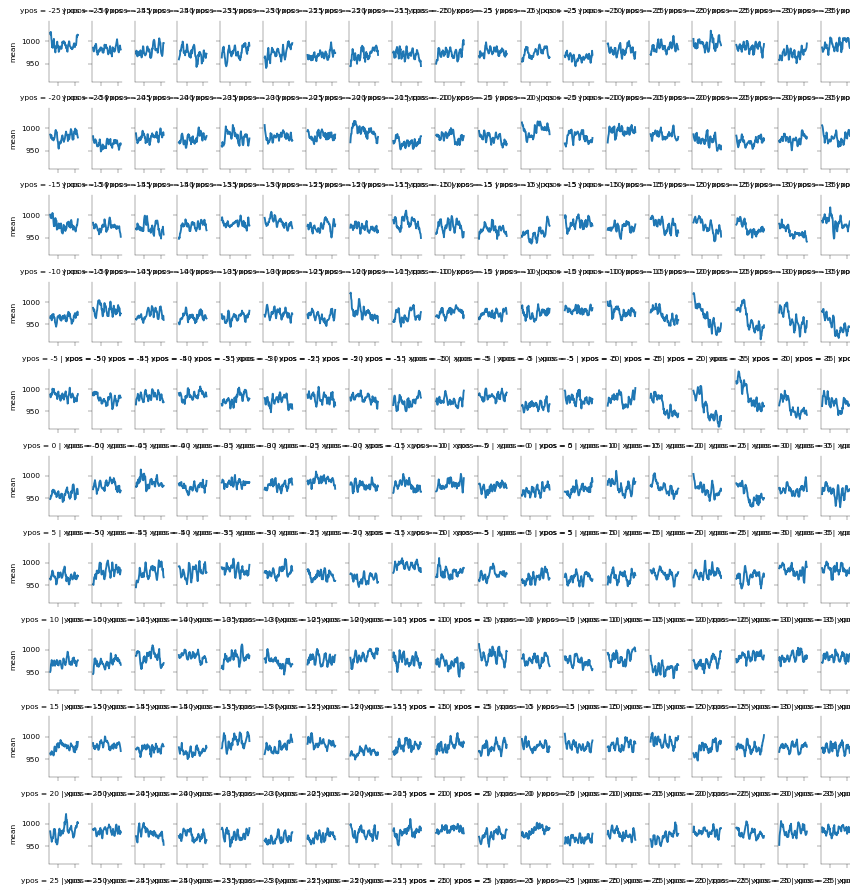

In [56]:
fg = sns.FacetGrid(col='xpos', row='ypos', data=tdf, height=1, aspect=0.5)
fg.map(pl.plot, 'time', 'mean' )

In [26]:
# Get RFMAPS
avg_resp_by_cond0 = rfutils.load_rfmap_array(fit_params['rfdir'], do_spherical_correction=do_spherical_correction)
# if avg_resp_by_cond0 is None:
#     trials_by_cond = rfutils.get_trials_by_cond(labels)
#     nx = len(fit_params['col_vals'])
#     ny = len(fit_params['row_vals'])
#     print("Error loading array, extracting now")
#     print("...getting avg by cond")
#     avg_resp_by_cond0 = rfutils.group_trial_values_by_cond(zscores, trials_by_cond, nx=nx, ny=ny,
#                                                 do_spherical_correction=do_spherical_correction)
#     if do_spherical_correction:
#         print("...doin spherical warps")
#         if n_processes>1:
#             avg_resp_by_cond0 = sphr_correct_maps_mp(avg_resp_by_cond0, fit_params,
#                                                         n_processes=n_processes, test_subset=test_subset)
#         else:
#             avg_resp_by_cond0 = sphr_correct_maps(avg_resp_by_cond0, fit_params,
#                                                         multiproc=False)
#     print("...saved array")
#     rfutils.save_rfmap_array(avg_resp_by_cond0, fit_params['rfdir'])
avg_resp_by_cond = avg_resp_by_cond0[fit_roi_list]   

In [27]:
# Stim info
stim_on_frame = labels['stim_on_frame'].unique()[0]
nframes_on = labels['nframes_on'].unique()[0]
stim_on_sec = round(stim_on_frame/44.65, 1)
nframes_plot = fit_params['stim_on_frame'] + fit_params['nframes_on'] + fit_params['nframes_post_onset']
start_frame = fit_params['stim_on_frame'] #stim_on_frame #plot_start_frame #stim_on_frame #0
yunit_sec = round(fit_params['nframes_on']/fit_params['frame_rate'], 1)
# Add stim info to labels df for plotting
labels['xpos'] = sdf.loc[labels['config']]['xpos'].values
labels['ypos'] = sdf.loc[labels['config']]['ypos'].values
# position info
xpos = list(sorted(sdf['xpos'].unique()))
ypos = list(sorted(sdf['ypos'].unique()))
row_vals=fit_params['row_vals']
col_vals=fit_params['col_vals']
n_xpos = len(xpos)
n_ypos = len(ypos)

In [28]:
plot_ellipse=True
ellipse_ec='w'
ellipse_fc='none'
ellipse_lw=0.5
ellipse_alpha=1

fill_sem=True
mean_only=False
ls='-'
lw=0.5
legend_lw = 0.5

scale_sigma=True
sigma_scale=2.35
linecolor='darkslateblue'
cmap='bone'
legend_lw=0.25

nframes_plot = fit_params['stim_on_frame'] + fit_params['nframes_on'] #+ fit_params['nframes_post_onset']
start_frame = fit_params['stim_on_frame'] #stim_on_frame #plot_start_frame #stim_on_frame #0
yunit_sec = 0.5 #1.0 #round(fit_params['nframes_on']/fit_params['frame_rate'], 1)
yunit_frames = yunit_sec*44.65

In [32]:
if va=='Lm' and dk=='20190603_JC080_fov1':
    example_roi_list = [85, 128, 170]
elif va=='Lm' and dk=='20190508_JC083_fov1':
    example_roi_list = [31, 209, 44] #237, 44]
elif va=='V1' and dk=='20190616_JC096_fov1':
    example_roi_list = [388, 381, 66]
elif va=='Li' and dk=='20190602_JC091_fov1':
    example_roi_list = [33,43,275]
elif va=='Li' and dk=='20190614_JC091_fov1':
    example_roi_list = [211,234,248]
elif va=='V1' and dk=='20190616_JC097_fov1':
    example_roi_list = [165, 172, 175]
else:
    example_roi_list = fit_roi_list[0:3]
example_roi_list

[165, 172, 175]

In [33]:
va, dk

('V1', '20190616_JC097_fov1')

In [37]:
rid = 164
rid in fit_roi_list

True

In [38]:

currt = labels.copy()
currt[response_type] = zscored_traces[rid].copy()
# Get curreent rf map
map_values = avg_resp_by_cond[rid].values
rfmap = np.flipud(map_values.reshape(len(col_vals), len(row_vals)).T) # fipud to match screen
print(rfmap.max())

0.021518647690837004


In [40]:
%matplotlib notebook
vmin=-0.1
vmax=0.1
set_ymax = vmax

ytick_max = 1.0
units = 'stds' if trace_type=='zscore' else 'df/f'

vmin = np.nanmin(rfmap) if vmin is None else vmin
vmax = np.nanmax(rfmap) if vmax is None else vmax
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cmapper = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
fig, axn = pl.subplots(n_ypos, n_xpos, figsize=(10, 5.7), sharex=True, sharey=True)
for (yp, xp), g in currt.groupby(['ypos', 'xpos']):
    yi = ypos[::-1].index(yp)
    xi = xpos.index(xp)
    ax=axn[yi, xi]
    #ax.set_title('%i, %i' % (xp, yp))
    ax.patch.set(alpha=1)
    pcolor = cmapper.to_rgba(rfmap[yi, xi])
    ax.patch.set_color(pcolor)
    t_df = g.groupby(['trial'])['dff'].apply(traceutils.smooth_traces_trial, win_size=5).unstack().T
    mean_t = np.nanmean(t_df, axis=1)[start_frame:start_frame+nframes_plot]
    std_t = np.nanstd(t_df, axis=1)[start_frame:start_frame+nframes_plot]
    sem_t = spstats.sem(t_df, axis=1, nan_policy='omit')[start_frame:start_frame+nframes_plot]
    ax.fill_between(np.arange(0, len(mean_t)), mean_t-sem_t, mean_t+sem_t, alpha=0.2, color='k')
    ax.plot(mean_t, lw=lw, c='k', linestyle=ls) #, label='%s %i' % (hue_, curr_hue))
    # format
    if not (xi==0 and yi==len(ypos)-1):
        sns.despine(bottom=True, left=True, ax=ax)
    else:
        sns.despine(trim=True, ax=ax) #, bottom=True, left=True, ax=ax)  
    ax.set_xticks([stim_on_frame, stim_on_frame+nframes_on])
    ax.tick_params(which='both', axis='both', size=0)
    ax.set_xticklabels([])
    ax.set_xlabel('') 
    # Make sure y-ticks are limited correctly
    ax.set_yticks(np.linspace(0, ytick_max, 3)) #[0.0, 0.1, 0.2])
    ax.set_yticklabels(['', '%.1f %s' % (ytick_max, units), ''], rotation=90)

# Set axis LIMITS for ALL, just make sure it's the same
subplot_xlims = ax.get_xlim() 
subplot_ylims = ax.get_ylim() 
ax.set_ylim(subplot_ylims)
ax.set_xlim(subplot_xlims)
subplot_pos = ax.get_position()
for ax in axn.flat: #axes.flat:
    ax.set_ylim(subplot_ylims)
    ax.set_xlim(subplot_xlims)
    ax.tick_params(axis='both', which='both', length=0, labelsize=0)
    ax.set_xticks([])
    ax.set_yticks([])
    curr_pos = ax.get_position()
    new_pos = [curr_pos.x0, curr_pos.y0, subplot_pos.width, subplot_pos.height] #.1, .1]
    ax.set_position(new_pos)
pl.subplots_adjust(left=0.02, right=0.8, wspace=0, hspace=0)

# plot ellipse
pos_ylim = (min(row_vals), max(row_vals))
pos_xlim = (min(col_vals), max(col_vals))
screen_xlim_centered = rfutils.get_centered_screen_points(pos_xlim, n_xpos)
screen_ylim_centered = rfutils.get_centered_screen_points(pos_ylim, n_ypos)
outergs = gridspec.GridSpec(1,1)
outerax = fig.add_subplot(outergs[0])
outerax.tick_params(axis='both', which='both', bottom=0, left=0,
                labelbottom=0, labelleft=0)
outerax.set_facecolor('crimson')
outerax.patch.set_alpha(0.1)
outerax = fig.add_subplot(outergs[0])
outerax.set_ylim(screen_ylim_centered) #[screen_bottom, screen_top])
outerax.set_xlim(screen_xlim_centered) #[screen_left, screen_right])

ell = mpl.patches.Ellipse((fitdf['x0'][rid], fitdf['y0'][rid]),
                abs(fitdf['sigma_x'][rid])*sigma_scale,
                abs(fitdf['sigma_y'][rid])*sigma_scale,
                angle=np.rad2deg(fitdf['theta'][rid]))
ell.set_alpha(ellipse_alpha)
ell.set_edgecolor(ellipse_ec)
ell.set_facecolor(ellipse_fc)
ell.set_linewidth(ellipse_lw)
outerax.add_patch(ell)
# Add colorbar for RF map
cmapper._A = []
cbar_ax = fig.add_axes([0.81, 0.15, 0.015, 0.3])
cbar = fig.colorbar(cmapper, cax=cbar_ax)
cbar.set_label('%s' % response_type)
cbar.set_ticks([vmin, vmax])
cbar.set_ticklabels([round(vmin, 2), round(vmax, 2)])
cbar.ax.tick_params(axis='both', which='both', length=0, pad=1)

# Add legend for traces
legend_pos = [0.83, 0.75, subplot_pos.width, subplot_pos.height] #.1, .1]
leg = fig.add_subplot(111, position=legend_pos) #, aspect='auto')
leg.clear()
leg.plot(mean_t, 'w', alpha=1)
leg.set_ylim(subplot_ylims)
leg.set_xlim(subplot_xlims)
ymax = ax.get_ylim()[-1] if set_ymax is None else set_ymax
yscale = min([ymax, 2.0]) if trace_type=='zscore' else min([ymax, 0.5])
# set lim
ymin, ymax = subplot_ylims
leg.set_yticks([ymin, ymin+yscale])
yunits = 'std' if trace_type=='zscore' else response_type
leg.set_ylabel('%.1f %s' % (yscale, yunits))
xmin, xmax = subplot_xlims
leg.set_xticks([xmin, xmin+yunit_frames])
leg.set_xticklabels([])
# legends
leg.tick_params(axis='both', which='both', size=0, labelsize=0, pad=0.01)
for axlabel in ['left', 'bottom']:
    leg.spines[axlabel].set_linewidth(legend_lw)
leg.set_xlabel('%.1f s' % yunit_sec, horizontalalignment='left', x=0)
sns.despine(ax=leg, trim=True, offset=0) #, bottom=False)

pplot.label_figure(fig, data_id)
fig.suptitle('roi %i' % int(rid+1))
figname = '%s_%s_roi%05d_overlay_test' % (va, dk, int(rid+1))
# pl.savefig(os.path.join(curr_dst_dir, '%s.pdf' % (figname)), bboxx_inches='tight')
print(curr_dst_dir, figname)

<IPython.core.display.Javascript object>


KeyboardInterrupt



In [50]:
importlib.reload(traceutils)

<module 'analyze2p.extraction.traces' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/extraction/traces.py'>

In [124]:
# def plot_rfs_to_screen_pretty(fitdf, sdf, screen, sigma_scale=2.35, fit_roi_list=[], ax=None,
#                              ellipse_lw=1, roi_colors=None):
#     '''
#     fitdf:  dataframe w/ converted fit params
#     '''
#     screen_left = -1*screen['azimuth_deg']/2.
#     screen_right = screen['azimuth_deg']/2.
#     screen_top = screen['altitude_deg']/2.
#     screen_bottom = -1*screen['altitude_deg']/2.
    
#     row_vals = sorted(sdf[rows].unique())
#     col_vals = sorted(sdf[cols].unique())
#     tile_sz = np.mean(np.diff(row_vals))
#     screen_rect = mpl.patches.Rectangle(
#                 ( min(col_vals)-tile_sz/2., min(row_vals)-tile_sz/2.), 
#                 max(col_vals)-min(col_vals)+tile_sz,
#                 max(row_vals)-min(row_vals)+tile_sz, 
#                 facecolor='none', edgecolor='k', lw=0.5)
#     ax.add_patch(screen_rect)
#     if ax is None:
#         fig, ax = pl.subplots(figsize=(12, 6))
#         fig.patch.set_visible(False) #(False) #('off')
#     if roi_colors is None:
#         roi_colors=sns.color_palette('bone', n_colors=len(fit_roi_list)+5) 
#     for rid, rcolor in zip(fit_roi_list, roi_colors):
#         ell = mpl.patches.Ellipse((fitdf['x0'][rid], fitdf['y0'][rid]),
#                       abs(fitdf['sigma_x'][rid])*sigma_scale, abs(fitdf['sigma_y'][rid])*sigma_scale,
#                       angle=np.rad2deg(fitdf['theta'][rid]))
#         ell.set_alpha(1.0)
#         ell.set_linewidth(ellipse_lw)
#         ell.set_edgecolor(rcolor)
#         ell.set_facecolor('none')
#         ax.add_patch(ell)
#     ax.set_ylim([screen_bottom, screen_top])
#     ax.set_xlim([screen_left, screen_right])
    
#     ax.set_xticks([])
#     ax.set_xticklabels([])
#     ax.set_yticks([])
#     ax.set_yticklabels([])
#     #summary_str = "Avg sigma-x, -y: (%.2f, %.2f)\nAvg RF size: %.2f (min: %.2f, max: %.2f)" % (np.mean(majors), np.mean(minors), np.mean([np.mean(majors), np.mean(minors)]), avg_rfs.min(), avg_rfs.max())
#     #pl.text(ax.get_xlim()[0]-12, ax.get_ylim()[0]-8, summary_str, ha='left', rotation=0, wrap=True)
#     return ax


In [125]:
screen = hutils.get_screen_dims()
screen

{'azimuth_deg': 119.5564,
 'altitude_deg': 67.323,
 'azimuth_cm': 103.0,
 'altitude_cm': 58.0,
 'resolution': [1920, 1080],
 'deg_per_pixel': (0.06226895833333333, 0.062336111111111106)}

<IPython.core.display.Javascript object>


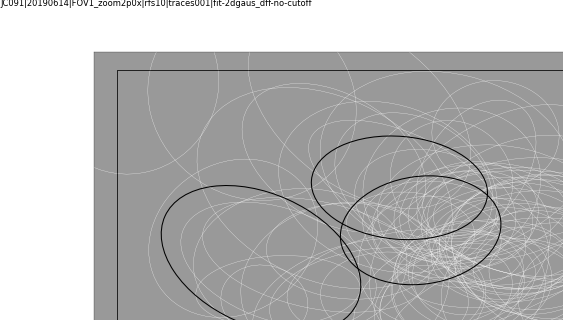

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bboxx_inches" which is no longer supported as of 3.3 and will become an error two minor releases later


/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields screen_rfs__Li_20190614_JC091_fov1_test


In [126]:
fig, ax = pl.subplots(figsize=(10, 5.7))
fig.patch.set_visible(False) #(False) #('off')

other_rois = [r for r in fit_roi_list if r not in example_roi_list]
ax = rfutils.plot_rfs_to_screen_pretty(fitdf, sdf, screen, 
                               sigma_scale=fit_params['sigma_scale'],
                               fit_roi_list=other_rois, ax=ax, 
                               roi_colors=['w']*len(other_rois), ellipse_lw=0.25)

ax = rfutils.plot_rfs_to_screen_pretty(fitdf, sdf, screen, 
                               sigma_scale=fit_params['sigma_scale'],
                               fit_roi_list=example_roi_list, ax=ax, 
                               roi_colors=['k']*3, ellipse_lw=1)
ax.patch.set_color([0.6]*3)
ax.patch.set_alpha(1)

pplot.label_figure(fig, data_id)
figname = 'screen_rfs__%s_%s_test' % (va, dk)
pl.savefig(os.path.join(dst_dir, '%s.pdf' % (figname)), bboxx_inches='tight')

print(dst_dir, figname)

# Combine them meh?

In [39]:
importlib.reload(p3)

<module 'py3utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/notebooks/response_stats/py3utils.py'>

In [30]:
combined_rfs = rfutils.average_rfs_select(rfdata)


In [31]:
combined_rfs.groupby(['visual_area', 'experiment']).count()

datakey  animalid  session  fov_xpos  fov_xpos_pix  \
visual_area experiment                                                        
Li          average_rfs       33        33       33        33            33   
            rfs               16        16       16        16            16   
            rfs10            379       379      379       379           379   
Lm          average_rfs       10        10       10        10            10   
            rfs              349       349      349       349           349   
            rfs10             44        44       44        44            44   
V1          rfs              637       637      637       637           637   

                         fov_ypos  fov_ypos_pix  ml_pos  ap_pos  cell  ...  \
visual_area experiment                                                 ...   
Li          average_rfs        33            33      33      33    33  ...   
            rfs                16            16      16      16    16  ...   
            rfs10             379           379     379     379   379  ...   
Lm          average_rfs        10            10      10      10    10  ...   
            rfs               349           349     349     349   349  ...   
            rfs10              44            44      44      44    44  ...   
V1          rfs               637           637     637     637   637  ...   

                          fx   fy  ratio_xy  theta_c  theta_Mm_deg  \
visual_area experiment                                               
Li          average_rfs   33   33        33       33            33   
            rfs           16   16        16       16            16   
            rfs10        379  379       379      379           379   
Lm          average_rfs   10   10        10       10            10   
            rfs          349  349       349      349           349   
            rfs10         44   44        44       44            44   
V1          rfs          637  637       637      637           637   

                         major_axis  minor_axis  anisotropy  theta_Mm_c  \
visual_area experiment                                                    
Li          average_rfs          33          33          33          33   
            rfs                  16          16          16          16   
            rfs10               379         379         379         379   
Lm          average_rfs          10          10          10          10   
            rfs                 349         349         349         349   
            rfs10                44          44          44          44   
V1          rfs                 637         637         637         637   

                         aniso_index  
visual_area experiment                
Li          average_rfs           33  
            rfs                   16  
            rfs10                379  
Lm          average_rfs           10  
            rfs                  349  
            rfs10                 44  
V1          rfs                  637  

[7 rows x 32 columns]

In [32]:
df_ = []
for (va, dk), g in combined_rfs.groupby(['visual_area', 'datakey']):
    if va=='Lm':
        d_ = g[g.experiment.isin(['average_rfs', 'rfs'])]
    elif va=='Li':
        d_ = g[g.experiment.isin(['average_rfs', 'rfs10'])]
    else:
        d_ = g.copy()
    df_.append(d_)
avgrfs = pd.concat(df_)


In [33]:
final_counts = avgrfs.groupby(['visual_area', 'datakey'])['cell'].count().reset_index()
final_counts.groupby(['visual_area']).sum()

,cell
visual_area,
Li,412
Lm,359
V1,637


#### Drop repeats

In [34]:
rf_type='combinedrfs'
# Only include rf-5 ----------------------------------------------
best_ = p3.select_best_fovs(final_counts, criterion='max')
final_rf_keys = list((va, dk) for (va, dk) in \
                     best_[['visual_area', 'datakey']].values)
# Check with examples (rf-5):
# ('Lm', '20190506_JC080_fov1') OR ('Lm', '20190603_JC080_fov1')
# ('Lm', '20190506_JC080_fov1') in rf5_keys
# ('Lm', '20190603_JC080_fov1') in rf5_keys #best_rf5[['visual_area', 'datakey']].values

[V1] Animalid does not exist: JC078 


In [222]:
#### Current output dir
curr_dst_dir = os.path.join(dst_dir,  'combined_rfs')
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print(curr_dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/combined_rfs


# Aggr metrics

In [45]:
curr_dst_dir = os.path.join(dst_dir, 'combined_rfs')
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print(curr_dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/combined_rfs


In [46]:
aggdf = pd.concat([rfs_ for (va, dk), rfs_ in avgrfs.groupby(['visual_area', 'datakey']) \
                       if (va, dk) in final_rf_keys])

aggdf.groupby(['visual_area']).count()


,datakey,animalid,session,fov_xpos,fov_xpos_pix,fov_ypos,fov_ypos_pix,ml_pos,ap_pos,cell,...,fy,ratio_xy,theta_c,theta_Mm_deg,major_axis,minor_axis,anisotropy,theta_Mm_c,aniso_index,experiment
visual_area,,,,,,,,,,,,,,,,,,,,,
Li,279,279,279,279,279,279,279,279,279,279,...,279,279,279,279,279,279,279,279,279,279
Lm,241,241,241,241,241,241,241,241,241,241,...,241,241,241,241,241,241,241,241,241,241
V1,548,548,548,548,548,548,548,548,548,548,...,548,548,548,548,548,548,548,548,548,548


In [47]:
avgrfs.groupby(['visual_area']).count()


,datakey,animalid,session,fov_xpos,fov_xpos_pix,fov_ypos,fov_ypos_pix,ml_pos,ap_pos,cell,...,fy,ratio_xy,theta_c,theta_Mm_deg,major_axis,minor_axis,anisotropy,theta_Mm_c,aniso_index,experiment
visual_area,,,,,,,,,,,,,,,,,,,,,
Li,412,412,412,412,412,412,412,412,412,412,...,412,412,412,412,412,412,412,412,412,412
Lm,359,359,359,359,359,359,359,359,359,359,...,359,359,359,359,359,359,359,359,359,359
V1,637,637,637,637,637,637,637,637,637,637,...,637,637,637,637,637,637,637,637,637,637


<IPython.core.display.Javascript object>


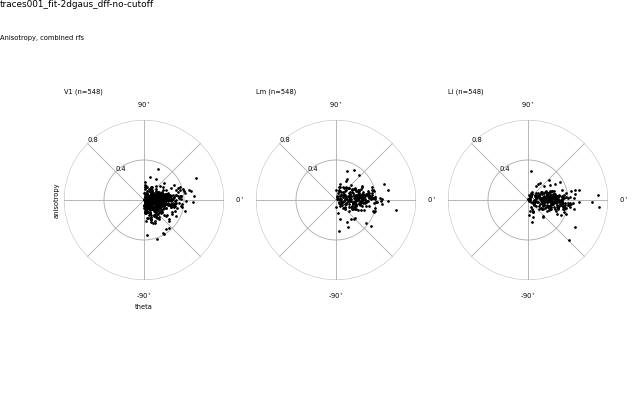

/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  """


In [147]:
markersize=2
alpha=1
fontsize=6

cmap='spring_r'
metric='anisotropy'
fig, axn = pl.subplots(1, 3, subplot_kw=dict(projection='polar'), figsize=(8,5))
for va, vg in aggdf.groupby(['visual_area']):
    ai= visual_areas.index(va)
    ax = axn[ai]
    #ax = fig.add_subplot(2, 3, ai+3+1, projection="polar")
    thetas = vg['theta_Mm_c'].values #% np.pi # all thetas should point the same way
    ratios = vg['anisotropy'].values
    ax.scatter(thetas, ratios, marker='o', s=markersize, c='k', zorder=10000) #c=area_colors[va])
    pplot.adjust_polar_axes(ax)
    if ai!=0:
        ax.set_ylabel('')
    else:
        ax.set_ylabel('anisotropy', fontsize=fontsize)
        ax.set_xlabel('theta', fontsize=fontsize)
    ax.set_title('%s (n=%i)' % (va, len(g)), fontsize=6, loc='left')
pl.subplots_adjust(top=0.8, left=0.1, right=0.95, bottom=0.2)

p3.label_figure(fig, data_id)
fig.text(0, 0.9, 'Anisotropy, combined rfs')
pl.savefig(os.path.join(curr_dst_dir, 'anisotropy_bw.svg'))

In [226]:
importlib.reload(pplot)

<module 'plotting' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/notebooks/response_stats/plotting.py'>

In [228]:
pplot.print_means(aggdf, groupby=['visual_area'], params=plot_metrics)

MEANS:
  visual_area    std_avg         fx        fy  std_avg_std    fx_std    fy_std
0          Li  12.844248  13.110115  5.601796     2.334529  5.289588  5.290881
1          Lm  10.426276  10.992539  4.369795     3.241823  4.629802  4.129790
2          V1   9.014172   8.689770  4.125203     2.242779  3.602530  3.322433


In [244]:
importlib.reload(pplot)

<module 'plotting' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/notebooks/response_stats/plotting.py'>

<IPython.core.display.Javascript object>


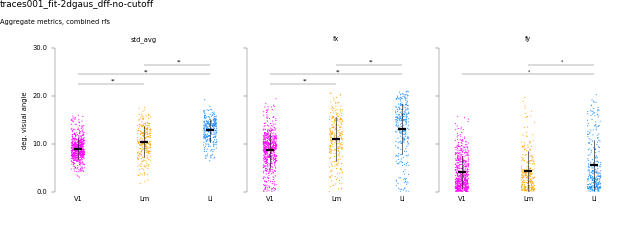

********* [std_avg] Mann-Whitney U test(mc=fdr_bh) **********
   d1  d2  reject         p_val    U_val   n1   n2
0  V1  Lm    True  2.563839e-12  45682.0  548  241
1  V1  Li    True  2.791056e-69  19229.0  548  279
2  Lm  Li    True  6.197716e-19  18487.0  241  279
****************************
********* [fx] Mann-Whitney U test(mc=fdr_bh) **********
   d1  d2  reject         p_val    U_val   n1   n2
0  V1  Lm    True  3.674058e-13  44720.5  548  241
1  V1  Li    True  4.818389e-37  35041.0  548  279
2  Lm  Li    True  1.264607e-08  24100.0  241  279
****************************
********* [fy] Mann-Whitney U test(mc=fdr_bh) **********
   d1  d2  reject     p_val    U_val   n1   n2
0  V1  Lm   False  0.390405  65213.0  548  241
1  V1  Li    True  0.030300  68951.0  548  279
2  Lm  Li    True  0.030300  30117.0  241  279
****************************


In [248]:
y_loc=22.5
plot_metrics = ['std_avg', 'fx', 'fy']

fig, axn = pl.subplots(1,len(plot_metrics),figsize=(8,3), sharey=True)
for ai, metric in enumerate(plot_metrics):
    ax=axn[ai]
    sns.stripplot(x='visual_area', y=metric, data=aggdf, ax=ax,
                 hue='visual_area', palette=area_colors,
                  order=visual_areas, zorder=-1, jitter=True,
                 s=markersize)
    sns.pointplot(x='visual_area', y=metric, data=aggdf, ax=ax,
                 color='k', order=visual_areas, zorder=-1,
                 markers='_', join=False, ci='sd', 
                 errwidth=0.5)
    ax.legend_.remove()
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_xlabel('')
    if ai==0:
        ax.set_ylabel('deg. visual angle')
    else:
        ax.set_ylabel('')
    ax.set_title(metric, fontsize=fontsize)
    # stats
    statdf, ax = pplot.plot_mannwhitney(aggdf, metric=metric, ax=ax,
                            multi_comp_test=multi_comp_test, y_loc=y_loc, 
                            offset=2, lw=0.25, fontsize=4)
ax.set_ylim([0, 30])
ax.set_yticks(np.linspace(0, 30, 4))
ax.set_yticklabels(np.linspace(0, 30, 4))
sns.despine(trim=True, offset=8, bottom=True)

pl.subplots_adjust(top=0.8, left=0.1, right=0.95, bottom=0.2)

p3.label_figure(fig, data_id)
fig.text(0, 0.9, 'Aggregate metrics, combined rfs')
pl.savefig(os.path.join(curr_dst_dir, 'size_metrics.svg'))

#### Overlap v. distance

In [390]:
# Calculate overlaps and distance (pairwise)
rf_fit_params = ['cell', 'std_x', 'std_y', 'theta', 'x0', 'y0']
# Convert RF fit params to polygon
d_=[]
for (va, dk), rfs_ in aggdf.groupby(['visual_area', 'datakey']):
    rois_ = rfs_['cell'].unique()
    if (va, dk) not in final_rf_keys:
        continue      
    rf_polys = rfutils.rfs_to_polys(rfs_[rf_fit_params])
    overlaps_ = rfutils.get_rf_overlaps(rf_polys)
    rfs_.index = rfs_['cell'].values
    # Coords of cell1 in pair, in order
    coords1 = np.array(rfs_.loc[overlaps_['poly1'].values][['ml_pos', 'ap_pos']])
    # Coords of cell2 in pair 
    coords2 = np.array(rfs_.loc[overlaps_['poly2'].values][['ml_pos', 'ap_pos']])
    # Get dists, in order of appearance
    dists = [np.linalg.norm(c1-c2) for c1, c2 in zip(coords1, coords2)]
    overlaps_['cortical_distance'] = dists
    overlaps_['visual_area'] = va
    overlaps_['datakey'] = dk
    d_.append(overlaps_)
overlaps = pd.concat(d_)
overlaps = overlaps.rename(columns={'poly1': 'cell_1', 'poly2': 'cell_2'})

In [393]:
overlaps[['visual_area', 'datakey']]\
    .drop_duplicates()['visual_area'].value_counts()

V1    11
Li    10
Lm     8
Name: visual_area, dtype: int64

In [394]:
del finaldf

NameError: name 'finaldf' is not defined

In [395]:
# Bin cortical distances for plotting
n_bins_dist = 6
n_bins_overlap = 8

use_quartile=False
bin_type = 'eqpop%i' % n_bins_dist if use_quartile else 'eqwidth%i' % n_bins_dist
print("binning: %s" % bin_type)

if use_quartile:
    overlaps['binned_dist'], bin_edges = pd.qcut(overlaps['cortical_distance'], \
                                    n_bins_dist, labels=False, retbins=True)
    #roi_df['binned_overlap'] = pd.cut(roi_df['perc_overlap'], n_bins_overlap, labels=False)
else:
    overlaps['binned_dist'], bin_edges = pd.cut(overlaps['cortical_distance'], \
                                     n_bins_dist,labels=False, retbins=True)
    #roi_df['binned_overlap'] = pd.cut(roi_df['perc_overlap'], n_bins_overlap, labels=False)

binning: eqwidth6


In [396]:
meanf = overlaps.groupby(['visual_area', 'datakey', 'binned_dist'])\
                .mean().reset_index()

<IPython.core.display.Javascript object>


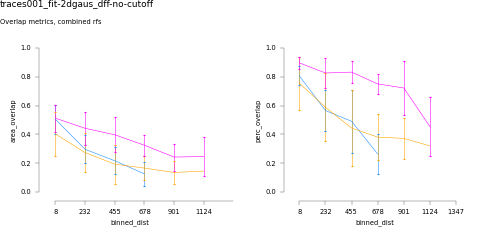

In [397]:
fig, axn = pl.subplots(1,2, figsize=(6,3), sharex=True, sharey=False)
for ax, metric in zip(axn.flat, ['area_overlap', 'perc_overlap']):
    sns.lineplot(x='binned_dist', y=metric, data=meanf, ax=ax,
                 hue='visual_area', palette=area_colors, 
                 ci='sd', err_style='bars',
                err_kws={'capsize':1, 'lw': lw}, lw=lw)
    ax.set_xticks(list(range(len(bin_edges))))
    ax.set_xticklabels([round(i) for i in bin_edges])
    ax.set_ylim([0, 1])
    sns.despine(offset=8, trim=True, ax=ax)
    ax.legend_.remove()
pl.subplots_adjust(top=0.8, left=0.1, right=0.95, bottom=0.2, wspace=0.5, hspace=0.5)

p3.label_figure(fig, data_id)
fig.text(0, 0.9, 'Overlap metrics, combined rfs')
pl.savefig(os.path.join(curr_dst_dir, 'overlap_by_distance.svg'))

<IPython.core.display.Javascript object>


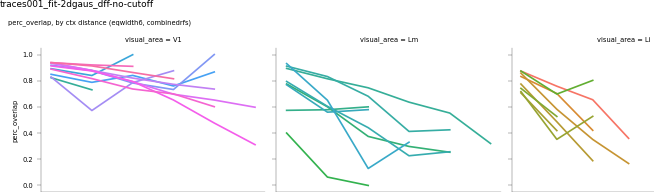

In [398]:
# fig, ax = pl.sublots()
metric = 'perc_overlap'
fg = sns.relplot(x='binned_dist', y=metric, hue='datakey',
                 data=meanf,col='visual_area', col_order=visual_areas,
                 kind='line', height=3)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)
fg.fig.text(0.01, 0.9, '%s, by ctx distance (%s, %s)' % (metric, bin_type, rf_type))
pl.xticks(list(range(len(bin_edges))))
fg.axes.flat[0].set_xticklabels([round(i) for i in bin_edges])
pl.subplots_adjust(left=0.05, right=0.9)
# fg.axes.flat[0].legend_.remove()
p3.label_figure(fg.fig, data_id)

figname =  'perFOV_%s_by_dist' % (metric)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))


In [403]:
importlib.reload(p3)

<module 'py3utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/notebooks/response_stats/py3utils.py'>

# On screen

In [404]:
# Convert to degrees
screen = p3.get_screen_dims()
screen_max = screen['azimuth_deg']/2.
screen_min = -screen_max

In [405]:
import retino_utils as retutils

In [540]:
def get_retino_metadata(sdata, 
                    roi_type='pixels', traceid=None,
                    return_errors=False,
                    rootdir='/n/coxfs01/2p-data', 
                    aggregate_dir='/n/coxfs01/julianarhee/aggregate-visual-areas'):
    '''
    Gets analysis ID info for ROI-based retino analyses.
    '''
    meta_list=[]
    no_retino=[]
    errors=[]
    for (va, animalid, session, fov), g in sdata.groupby(['visual_area', 'animalid', 'session', 'fov']):
        exp_list = [e for e in g['experiment'].values if 'retino' in e] 
        if len(exp_list)==0:
            print('... skipping, no retino (%s, %s, %s)' % (animalid, session, fov)) 
            continue
        retino_dirs = glob.glob(os.path.join(rootdir, animalid, session, fov,\
                                        'retino_*', 'retino_analysis'))
        # get analysis ids for non-pixel
        for retino_dir in retino_dirs:
            retino_run = os.path.split(os.path.split(retino_dir)[0])[-1]
            if traceid is None:
                try:
                    rid_fpath = glob.glob(os.path.join(retino_dir, 'analysisids_*.json'))[0]
                    with open(rid_fpath, 'r') as f:
                        retids = json.load(f)
                    retids = [r for r, res in retids.items() \
                                if res['PARAMS']['roi_type']==roi_type] 
                    assert len(retids)>0, "No ROI-based analyses"
                except Exception as e:
                    no_retino.append(retino_dir)
                    continue
                    
                for retid in retids: 
                    try:
                        fpath = os.path.join(rootdir, animalid, session, fov, retinorun,
                                    'retino_analysis', 'retino_structure', \
                                      'projections_%s.pkl' %  va)
                        assert os.path.exists(fpath), "No projection results (%s, %s, %s)" % (va, dk, retid)
                        meta_list.append(
                            tuple([va, animalid, session, fov, retino_run, retid, fpath]))
                    except Exception as e:
                        errors.append((retino_dir, retid))
                        continue
            else:
                fpath = os.path.join(rootdir, animalid, session, fov, retinorun,
                        'retino_analysis', 'retino_structure', \
                                  'projections_%s.pkl' %  va)
                meta_list.append(
                    tuple([va, animalid, session, fov, retino_run, traceid, fpath]))

    retmeta = pd.DataFrame(meta_list, 
        columns=['visual_area', 'animalid', 'session', \
                 'fov', 'retino_run', 'analysis_id','proj_path'])
    
    if return_errors:
        return retmeta, no_retino, errors
    else:
        return retmeta

# def get_projection_result_paths(retmeta, rootdir='/n/coxfs01/2p-data'):
#     retmeta['proj_path'] = None
#     proj_paths=[]; errors=[]; 
#     no_data=[];success=[];
#     for (va, animalid, session, fov, retinorun), g in \
#             retmeta.groupby(['visual_area', 'animalid', 'session', 'fov', 'retino_run']):
#         skey = '_'.join([va, session, animalid, fov, retinorun])
#         # Load data metainfo
#         retinoid, RETID = retutils.load_retino_analysis_info(animalid, session, fov, run=retinorun)
#         if RETID is None:
#             print('no data, %s' %skey)
#             no_data.append(skey)
#             continue
#         try:
#             fpath = os.path.join(rootdir, animalid, session, fov, retinorun,
#                         'retino_analysis', 'retino_structure', \
#                                   'projections_%s.pkl' %  va)
#             #assert os.path.exists(fpath), "No data: %s" %skey
#             retmeta.loc[g.index, 'proj_path'] = fpath
#             retmeta.loc[g.index, 'analysis_id'] = retinoid
# #             proj_paths.append((va, animalid, session, fov, retinorun, \
# #                                    retinoid, fpath))
#             success.append(skey)
#         except Exception as e:
#             errors.append(skey)
#             continue
#     print("%i of %i paths found" % (len(success), len(retmeta)))
#     return retmeta

In [408]:
import retino_utils as retutils

In [513]:
#### Filter RETINO datasets by
pass_criterion='pixels'
mag_thr = 0.003
mag_thr = 0.1 if pass_criterion=='npmean' else mag_thr
##### Results key identifier
magthr_str = '%s_thr-%.3f' % (pass_criterion, mag_thr)
print(magthr_str)

pixels_thr-0.003


In [549]:
retmeta = pd.concat([g for (va, dk), g in sdata.groupby(['visual_area', 'datakey'])\
            if ('retino' in g['experiment'].values)])
ret_keys = list((va, dk) for (va, dk) in \
                retmeta[['visual_area', 'datakey']].drop_duplicates().values)

In [541]:
print("Threshold info: %s" % magthr_str)
retino_meta, no_ret, errs = get_retino_metadata(retmeta, roi_type='pixels',
                                                return_errors=True, traceid=None)
# retino_meta = get_projection_result_paths(retino_meta)
print("%i without ROI analysis" % len(no_ret))
for r in no_ret: print('... %s' % r)
print("%i ERR loading projection vectors" % len(errs))
for r in errs: print('... %s' % str(r))
retino_meta = p3.add_datakey(retino_meta)

Threshold info: pixels_thr-0.003
1 without ROI analysis
... /n/coxfs01/2p-data/JC070/20190314/FOV1_zoom2p0x/retino_run2/retino_analysis
8 ERR loading projection vectors
... ('/n/coxfs01/2p-data/JC073/20190327/FOV1_zoom2p0x/retino_run1/retino_analysis', 'analysis001')
... ('/n/coxfs01/2p-data/JC073/20190327/FOV1_zoom2p0x/retino_run2/retino_analysis', 'analysis001')
... ('/n/coxfs01/2p-data/JC073/20190327/FOV1_zoom2p0x/retino_run3/retino_analysis', 'analysis001')
... ('/n/coxfs01/2p-data/JC070/20190314/FOV2_zoom2p0x/retino_run1/retino_analysis', 'analysis001')
... ('/n/coxfs01/2p-data/JC073/20190327/FOV1_zoom2p0x/retino_run1/retino_analysis', 'analysis001')
... ('/n/coxfs01/2p-data/JC073/20190327/FOV1_zoom2p0x/retino_run2/retino_analysis', 'analysis001')
... ('/n/coxfs01/2p-data/JC073/20190327/FOV1_zoom2p0x/retino_run3/retino_analysis', 'analysis001')
... ('/n/coxfs01/2p-data/JC076/20190422/FOV1_zoom2p0x/retino_run1/retino_analysis', 'analysis001')


In [926]:
def delete_files(folder):
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))
    return
import shutil
# Create dir to copy gradient images to, for visual inspection
copy_images = True
dst = os.path.join(curr_dst_dir, 'gradient_maps')
if not os.path.exists(dst):
    os.makedirs(dst)
if copy_images:
    delete_files(dst)
print(dst)


/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/combined_rfs/gradient_maps


In [937]:

def copy_gradient_maps(fpath, dst, prefix=None):
    src = os.path.split(fpath)[0]
    fimpaths = glob.glob(os.path.join(src, 'gradients*.svg'))
    fimpaths.extend(glob.glob(os.path.join(src, 'unitvec*.svg')))
    if len(fimpaths)==0:
        fimpaths = glob.glob(os.path.join(src, 'gradients*.png'))
        fimpaths.extend(glob.glob(os.path.join(src, 'unitvec*.png')))
    for fimpath in fimpaths:
        fname, fext = os.path.splitext(os.path.split(fimpath)[-1])
        fn = 'gradients' if 'gradients' in fname else 'unitvec'
        if prefix is None:
            new_fn = fname
        else:
            new_fn ='%s_%s%s' % (prefix, fn, fext)
        shutil.copyfile(fimpath, os.path.join(dst, new_fn))

In [941]:
d_list=[]
cols = ['visual_area', 'datakey', 'retino_run', 'analysis_id', 'proj_path']
for di, (va, dk, retinorun, retinoid, fpath) in enumerate(retino_meta[cols].values):
    if di % 20 == 0 or di==(len(retino_meta)-1):
        print("%i of %i gradient result files loaded." % (int(di+1), len(retino_meta)))
    with open(fpath, 'rb') as f:
        res = pkl.load(f, encoding='latin1')
    tmpd = res['regr_df'].copy()
    metainfo = {'visual_area': va,  'datakey': dk, 
                'retinorun': retinorun, 'retinoid': retinoid, 'fpath':fpath}
    tmpd = p3.add_meta_to_df(tmpd, metainfo)
    d_list.append(tmpd)
    if copy_images:
        prefix= '%s_%s_%s' % (va, dk, retinorun)
        copy_gradient_maps(fpath, dst, prefix=None)
    
projection_df = pd.concat(d_list, axis=0).reset_index(drop=True)
projection_df['abs_coef'] = abs(projection_df['coefficient'])
projection_df['cortical_mag'] = 1./projection_df['abs_coef']

1 of 83 gradient result files loaded.
21 of 83 gradient result files loaded.
41 of 83 gradient result files loaded.
61 of 83 gradient result files loaded.


In [942]:
    with open(fpath, 'rb') as f:
        res = pkl.load(f, encoding='latin1')
    tmpd = res['regr_df'].copy()
    tmpd

,R2,RMSE,coefficient,cond,intercept,pearson_p,pearson_r
0,0.993061,0.443463,0.020048,az,18.048521,0.0,0.996525
1,0.991681,0.393776,0.014254,el,-14.486875,0.0,0.995832


In [943]:
    src = os.path.split(fpath)[0]
    fimpaths = glob.glob(os.path.join(src, 'gradients*.svg'))
    fimpaths.extend(glob.glob(os.path.join(src, 'unitvec*.svg')))
    if len(fimpaths)==0:
        fimpaths = glob.glob(os.path.join(src, 'gradients*.png'))
        fimpaths.extend(glob.glob(os.path.join(src, 'unitvec*.png')))

In [945]:
fimpaths

['/n/coxfs01/2p-data/JC097/20190617/FOV1_zoom2p0x/retino_run1/retino_analysis/retino_structure/gradients_V1.png']

In [563]:
# Drop repeated retino run
best_retino = retutils.select_strongest_retinorun(projection_df)
best_retino['retinokey'] = ['%s_%s' % (dk, rrun) for dk, rrun \
                            in best_retino[['datakey', 'retinorun']].values]
print(projection_df.shape, best_retino.shape)

(166, 14) (140, 15)


In [564]:
# Select FOVs with BOTH azimuth and elevation passed
retino_r2_thr=0.5
projdf = pd.concat([g for (varea, datakey, retinorun), g \
                in best_retino.groupby(['visual_area', 'datakey', 'retinorun']) \
                if ((g[g['cond']=='az']['R2'].values > retino_r2_thr) \
                and (g[g['cond']=='el']['R2'].values > retino_r2_thr))])
print(best_retino.shape, projdf.shape)

(140, 15) (124, 15)


In [570]:
# Match retino + RF datasets
all_retino_keys = list([tuple(v) for v in projdf[['visual_area', 'datakey']]\
                    .drop_duplicates().values])
rf_df = pd.concat([g for (va, dk), g in avgrfs.groupby(['visual_area', 'datakey'])\
                  if (va, dk) in all_retino_keys])

all_rf_keys = list([tuple(v) for v in rf_df[['visual_area', 'datakey']]\
                    .drop_duplicates().values])

# Select best RF by # cells (out of the retinos that pass)
final_counts = rf_df.groupby(['visual_area', 'datakey'])['cell'].count().reset_index()
print(len(all_rf_keys), len(all_retino_keys))
best_ = p3.select_best_fovs(final_counts, criterion='max')
final_rf_keys = list((va, dk) for (va, dk) in \
                     best_[['visual_area', 'datakey']].values)

40 62
[V1] Animalid does not exist: JC078 


In [571]:
final_dkeys = [k for k in all_retino_keys if k in final_rf_keys]
print(len(final_dkeys), len(final_rf_keys))

26 26


In [830]:
final_proj = pd.concat([g for (va, dk), g in projdf.groupby(['visual_area', 'datakey']) \
                        if (va, dk) in final_dkeys])
final_rfs = pd.concat([g for (va, dk), g in avgrfs.groupby(['visual_area', 'datakey']) \
                        if (va, dk) in final_dkeys])


In [765]:
final_proj[['visual_area', 'datakey']].drop_duplicates()\
.groupby(['visual_area']).count()

,datakey
visual_area,
Li,9
Lm,7
V1,10


In [537]:
retinodf = pd.concat([ret_ for (va, dk), ret_ in projdf.groupby(['visual_area', 'datakey']) \
                       if (va, dk) in final_rf_keys])

In [538]:
retinodf[['visual_area', 'datakey', 'retinorun']].drop_duplicates()\
.groupby(['visual_area']).count()

,datakey,retinorun
visual_area,,
Li,9,9
Lm,7,7
V1,9,9


In [423]:
aggdf[['visual_area', 'datakey']].drop_duplicates()\
.groupby(['visual_area']).count()

,datakey
visual_area,
Li,10
Lm,8
V1,11


In [424]:
# final_rfs = aggdf.copy()
# final_proj = retinodf.copy()

In [849]:
def add_transformed_positions(final_rfs, final_proj):
    '''
    Load projection vectors (vectors_VA.pkl) provided by final_proj.
    Apply transform to ROI positions, 
    i.e., convert [ap_pos, ml_pos] --> [ml_proj, ap_proj]
    '''
    f0 = final_rfs.copy()
    f0['ml_proj'] = None
    f0['ap_proj'] = None
    for (va, dk), rfs_ in final_rfs.groupby(['visual_area', 'datakey']):
        ret_ = final_proj[(final_proj['visual_area']==va) 
                        & (final_proj['datakey']==dk)].copy()
        if ret_.shape[0]==0:
            print("... no pass retino: (%s, %s)" % (va, dk))
            continue
        # Get gradient_results path (vectors_VA.pkl) and load projection vectors
        assert len(ret_['fpath'].unique())==1, "[%s] Found retino path found: %s" \
                                            % (dk, str(ret_['fpath'].unique()))
        fpath = ret_['fpath'].unique()[0]
        gpaths = glob.glob(os.path.join(os.path.split(fpath)[0],
                                        'vectors_%s.pkl' % va))
        gpaths = [f for f in gpaths if '_pixels_thr' not in f] 
        assert len(gpaths)==1, "[%s, %s] Found retino path found: %s" \
                                                    % (dk, exp, str(gpaths))
        with open(gpaths[0], 'rb') as f:
            gresults = pkl.load(f, encoding='latin1')
        # Project FOV coordinates
        f0.loc[rfs_.index, 'ml_proj'] =np.array([np.dot(np.array((ml, ap)), gresults['az']) \
                                              for ap, ml in rfs_[['ap_pos', 'ml_pos']].values])
        f0.loc[rfs_.index, 'ap_proj'] = np.array([np.dot(np.array((ml, ap)), gresults['el']) \
                                              for ap, ml in rfs_[['ap_pos', 'ml_pos']].values])
    return f0
    

In [850]:
def filter_gradient_fits(final_proj, pass_crit='both', fit_thr=0.5):
    '''
    Filter gradient fits (projections) for retino data.
    '''
    if pass_crit=='both':
        filtproj = pd.concat([g for k, g in final_proj.groupby(['visual_area', 'datakey', 'retinorun']) \
                                if ((g[g['cond']=='az']['R2'].values>fit_thr) \
                                    and (g[g['cond']=='el']['R2'].values>fit_thr))])
    else:
        filtproj = pd.concat([g for k, g in final_proj.groupby(['visual_area', 'datakey', 'retinorun']) \
                                if ((g[g['cond']=='az']['R2'].values>fit_thr) \
                                    or (g[g['cond']=='el']['R2'].values>fit_thr))])
    return filtproj

In [901]:
def calculate_scatter_metrics_split_exp(final_rfs, final_proj, min_ncells=5):
    not_enough_cells_fit = []
    bad_fits = []
    d_list = []
    for (visual_area, datakey, rfname), rfs_ in \
                final_rfs.groupby(['visual_area','datakey', 'experiment']): #['V1', 'Lm', 'Li']:    
        if rfs_.shape[0] < min_ncells:
            print("--- too few cells (min%i), %s" % (min_ncells, datakey))
            not_enough_cells_fit.append(datakey)
            continue
        if datakey not in curr_gradients['datakey'].unique():
            print("--- bad gradient, %s" % datakey)
            continue
        # Get retino gradient
        ret_ = final_proj[(final_proj['visual_area']==visual_area) 
                            & (final_proj['datakey']==datakey)].copy()

        for cond, ret_cond in ret_.groupby(['cond']):
            xname = 'ml' if cond=='az' else 'ap'
            yname = 'x0' if cond=='az' else 'y0'
            max_degrees = screen['azimuth_deg']*20. if cond=='az' \
                                else screen['altitude_deg']*20.
            max_fovdist = 1177*20. if cond=='ap' else 972.*20.
            # Get RF fit info
            proj_locs = np.array(rfs_['%s_proj' % xname].values)
            rf_locs = np.array(rfs_[yname].values)
            rf_cell_ids = rfs_['cell'].values
            # Get dist to line:
            slope = float(ret_cond['coefficient'])
            intercept = float(ret_cond['intercept'])
            r2 = float(ret_cond['R2'])
            predicted_rf_locs = slope*proj_locs + intercept
            # Calculate DEG and DIST scattered
            deg_sc = abs(rf_locs - predicted_rf_locs).astype(float)
            deg_ixs = [i for i, v in enumerate(deg_sc) if v < max_degrees] # filter out illegal vals
            dist_sc = abs(proj_locs - (rf_locs - intercept)/slope).astype(float)
            dist_ixs = [i for i, v in enumerate(dist_sc) if v < max_fovdist] # filter out illegal vals
            # Only keep if both deg + dist calculated
            keep_ixs = np.intersect1d(deg_ixs, dist_ixs)
            n_pts = len(keep_ixs)
            if (n_pts)==0:
                bad_fits.append((datakey, cond))
                continue
            #print("... (%s) deg: %i of %i in bounds" % (cond, len(deg_ixs), len(deg_sc)))
            #print("... (%s) dist: %i of %i in bounds" % (cond, len(dist_ixs), len(dist_sc)))
            assert len(rf_cell_ids)==len(deg_sc)

            if any(np.isnan(dist_sc)):
                print(visual_area, datakey, r2)
                break
            if any(np.isnan(deg_sc)):
                print(visual_area, datakey, r2, deg_sc)
                break
            tmpd=pd.DataFrame({'cell': rf_cell_ids[keep_ixs],
                               'deg_scatter': deg_sc[keep_ixs],
                               'dist_scatter': dist_sc[keep_ixs],
                               'measured_rf': rf_locs[keep_ixs],
                               'predicted_rf': predicted_rf_locs[keep_ixs],
                               'measured_loc': proj_locs[keep_ixs],
                               'predicted_loc': (rf_locs[keep_ixs] - intercept)/slope,
                               'retino_R2': [r2 for _ in np.arange(0, n_pts)],
                               'axis': [cond for _ in np.arange(0, n_pts)],
                               'visual_area': [visual_area for _ in np.arange(0, n_pts)],
                               'datakey': [datakey for _ in np.arange(0, n_pts)],
                               'rfname': [rfname for _ in np.arange(0, n_pts)]
                         })
            d_list.append(tmpd)
    scatdf = pd.concat(d_list, axis=0)
    return scatdf

def calculate_scatter_metrics(final_rfs, final_proj, min_ncells=5):
    not_enough_cells_fit = []
    bad_fits = []
    d_list = []
    for (va, dk), rfs_ in final_rfs.groupby(['visual_area','datakey']):
        if rfs_.shape[0] < min_ncells:
            print("--- too few cells (min%i), %s" % (min_ncells, dk))
            not_enough_cells_fit.append(dk)
            continue
        if dk not in final_proj['datakey'].unique():
            print("--- bad gradient, %s" % dk)
            continue
        # Get retino gradient
        ret_ = final_proj[(final_proj['visual_area']==va) 
                            & (final_proj['datakey']==dk)].copy()
        if ret_.shape[0]==0:
            print("none:: %s" % dk)
        for cond, ret_cond in ret_.groupby(['cond']):
            xname = 'ml' if cond=='az' else 'ap'
            yname = 'x0' if cond=='az' else 'y0'
            max_degrees = screen['azimuth_deg']*20. if cond=='az' \
                                else screen['altitude_deg']*20.
            max_fovdist = 1177*20. if cond=='ap' else 972.*20.
            
            # Get RF fit info
            proj_locs = np.array(rfs_['%s_proj' % xname].values)
            #print(va, dk, cond, proj_locs)
            rf_locs = np.array(rfs_[yname].values)
            rf_cell_ids = rfs_['cell'].values
            # Get dist to line:
            slope = float(ret_cond['coefficient'])
            intercept = float(ret_cond['intercept'])
            r2 = float(ret_cond['R2'])
            predicted_rf_locs = slope*proj_locs + intercept
            # Calculate DEG and DIST scattered
            deg_sc = abs(rf_locs - predicted_rf_locs).astype(float)
            deg_ixs = [i for i, v in enumerate(deg_sc) if v < max_degrees] # filter out illegal vals
            dist_sc = abs(proj_locs - (rf_locs - intercept)/slope).astype(float)
            dist_ixs = [i for i, v in enumerate(dist_sc) if v < max_fovdist] # filter out illegal vals
            # Only keep if both deg + dist calculated
            keep_ixs = np.intersect1d(deg_ixs, dist_ixs)
            n_pts = len(keep_ixs)
            if (n_pts)==0:
                bad_fits.append((datakey, cond))
                continue
            #print("... (%s) deg: %i of %i in bounds" % (cond, len(deg_ixs), len(deg_sc)))
            #print("... (%s) dist: %i of %i in bounds" % (cond, len(dist_ixs), len(dist_sc)))
            assert len(rf_cell_ids)==len(deg_sc)
            tmpd=pd.DataFrame({
                       'cell': rf_cell_ids[keep_ixs],
                       'deg_scatter': deg_sc[keep_ixs],
                       'dist_scatter': dist_sc[keep_ixs],
                       'measured_rf': rf_locs[keep_ixs],
                       'predicted_rf': predicted_rf_locs[keep_ixs],
                       'measured_loc': proj_locs[keep_ixs],
                       'predicted_loc': (rf_locs[keep_ixs] - intercept)/slope})
            tmpd['retino_R2'] = r2
            tmpd['axis'] = cond
            tmpd['visual_area'] = va
            tmpd['datakey'] = dk
            tmpd['rfname'] = 'combined'
            d_list.append(tmpd)
    scatdf = pd.concat(d_list, axis=0)
    return scatdf

def combine_scatter_metrics(scatdf):
    all_cols = [k for k in scatdf.columns if k!='dist_scatter']
    sd1 = scatdf[all_cols].copy().rename(columns={'deg_scatter': 'scatter_val'})
    sd1['scatter_label'] = 'vf_deg'

    all_cols = [k for k in scatdf.columns if k!='deg_scatter']
    sd2 = scatdf[all_cols].copy().rename(columns={'dist_scatter': 'scatter_val'})
    sd2['scatter_label'] = 'ctx_dist'

    sd = pd.concat([sd1, sd2], axis=0)
    return sd


In [902]:
#rfname = 'rfs10'
min_ncells=5
retino_r2_thr=0.75
retino_pass_crit='both' 
final_rfs = add_transformed_positions(final_rfs, final_proj)
# Filter gradient data
curr_gradients = filter_gradient_fits(final_proj, pass_crit=retino_pass_crit,
                                      fit_thr=retino_r2_thr)
scatdf = calculate_scatter_metrics(final_rfs, curr_gradients, min_ncells=5)
print(scatdf.shape)

sd = combine_scatter_metrics(scatdf)
mean_sc = sd.groupby(['visual_area', 'datakey', 'axis',  'scatter_label']).mean().reset_index()

--- too few cells (min5), 20190522_JC089_fov1
--- bad gradient, 20190609_JC099_fov1
--- too few cells (min5), 20190517_JC083_fov1
(1984, 12)


In [903]:
axis_palette={'az': [0.8]*3, 'el': [0.6]*3}

In [904]:
#rfname = 'rfs10'
min_ncells=5
retino_r2_thr=0.75
retino_pass_crit='both' 
all_rfs = add_transformed_positions(rf_df, projdf)
# Filter gradient data
all_gradients = filter_gradient_fits(projdf, pass_crit=retino_pass_crit,
                                      fit_thr=retino_r2_thr)
scatdf_all = calculate_scatter_metrics(all_rfs, all_gradients, min_ncells=5)
print(scatdf_all.shape)

scat_comb_all = combine_scatter_metrics(scatdf_all)
mean_sc_all = scat_comb_all.groupby(['visual_area', 'datakey', 'axis',  'scatter_label']).mean().reset_index()

--- too few cells (min5), 20190522_JC089_fov1
--- bad gradient, 20190607_JC091_fov1
--- bad gradient, 20190609_JC099_fov1
none:: 20190612_JC099_fov1
--- too few cells (min5), 20191111_JC120_fov1
--- bad gradient, 20190509_JC078_fov1
--- bad gradient, 20190509_JC078_fov1
--- too few cells (min5), 20190517_JC083_fov1
(2468, 12)


In [905]:
'20190616_JC097_fov1' in mean_sc_all['datakey'].values

True

In [906]:
s_=[]
for sc, mc in mean_sc.groupby(['scatter_label']):
    s0 = p3.paired_ttests(mc, metric='scatter_val', 
                        c1='az', c2='el', compare_var='axis', 
                        ttest=False)
    s0['scatter_label'] = sc
    s_.append(s0)
statdf = pd.concat(s_)
statdf

,t_stat,p_val,visual_area,scatter_label
0,2.0,0.011719,V1,ctx_dist
1,0.0,0.015625,Lm,ctx_dist
2,5.0,0.156250,Li,ctx_dist
0,19.0,0.734375,V1,vf_deg
1,1.0,0.031250,Lm,vf_deg
2,4.0,0.109375,Li,vf_deg


In [907]:
pplot.print_means(mean_sc, groupby=[ 'scatter_label', 'visual_area'], 
                                  params=['scatter_val'])

MEANS:
  scatter_label visual_area  scatter_val  scatter_val_std
0      ctx_dist          Li   110.388455        57.382729
1      ctx_dist          Lm   194.127127        88.348792
2      ctx_dist          V1   244.066149       126.056928
3        vf_deg          Li     5.932952         2.875416
4        vf_deg          Lm     6.251506         2.506645
5        vf_deg          V1     3.117185         1.045797


<IPython.core.display.Javascript object>


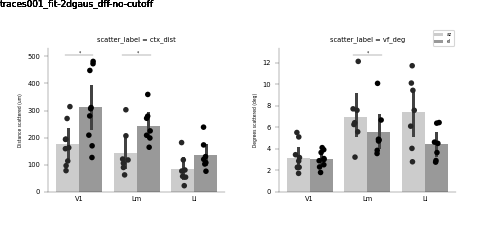

ctx_dist 505.2441615096433
vf_deg 12.715954641459273
/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/combined_rfs scatter_dist_and_deg


In [908]:
fg = sns.FacetGrid(mean_sc, col='scatter_label', height=3, aspect=1,sharey=False)
fg.map(sns.barplot, 'visual_area', 'scatter_val', 'axis', 
       order=visual_areas, hue_order=['az', 'el'], palette=axis_palette)
fg.map(sns.stripplot, 'visual_area', 'scatter_val', 'axis', dodge=True, 
       order=visual_areas, hue_order=['az', 'el'], color='k')

bar_length=0.5
offset_frac = 0.25
fontsize=4
lw=0.25
for sl, g in statdf[statdf['p_val']<0.05].groupby(['scatter_label']):
    currax = fg.axes_dict[sl]
    yloc = currax.get_ylim()[-1]
    print(sl, yloc)
    offset = np.mean(np.diff(currax.get_yticks()))*offset_frac
    for va, gg in g.groupby(['visual_area']):
        vi = visual_areas.index(va)
        currax.plot( [vi-(bar_length/2.), vi+(bar_length/2.)], [yloc, yloc], 
                    color='k', lw=lw)
        star_str = '**' if float(gg['p_val'])<0.01 else '*'
        currax.text(vi, yloc, star_str, fontsize=fontsize)
    currax.tick_params(which='both', axis='x', size=0)
    currax.set_xlabel('')
    yl = 'Distance scattered (um)' if sl=='ctx_dist' else 'Degrees scattered (deg)'
    currax.set_ylabel(yl, fontsize=fontsize)
# Legend
fg.axes.flat[1].legend()
lh = pplot.crop_legend_labels(fg.axes.flat[1], n_hues=2, start_ix=2,
                            bbox_to_anchor=(1,1), loc='lower right', fontsize=fontsize)
pl.subplots_adjust(bottom=0.2, top=0.8, right=0.95, left=0.1, wspace=0.3)

pplot.label_figure(fg.fig, data_id)
figname = 'scatter_dist_and_deg'
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [874]:
sc

'vf_deg'

In [863]:
d_=[]
for (sl, va), vg in mean_sc.groupby(['scatter_label', 'visual_area']):
    a_vals = vg[vg['axis']=='az']['scatter_val'].values
    b_vals = vg[vg['axis']=='el']['scatter_val'].values
    diffs = b_vals-a_vals
    df_ = pd.DataFrame({'el_minus_az': diffs})
    df_['visual_area'] = va
    df_['scatter_label'] = sl
    d_.append(df_)
diffs = pd.concat(d_)    

In [864]:
diffs['visual_area'] = diffs['visual_area'].astype('category')

<IPython.core.display.Javascript object>


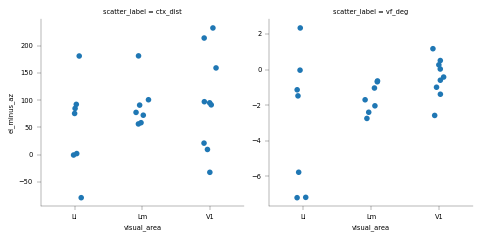

/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


In [865]:

fg=sns.FacetGrid(diffs, col='scatter_label', height=3, sharey=False)
fg.map(sns.stripplot, 'visual_area', 'el_minus_az')

#### Scatter example

In [1568]:
va = 'V1'
dk = '20190522_JC084_fov1' #'20190617_JC097_fov1'
# dk = '20190616_JC097_fov1'

df_= scatdf_all[(scatdf_all.visual_area==va) & (scatdf_all.datakey==dk)].copy()
scatter_cols = ['cell', 'predicted_rf', 'measured_rf', 'predicted_loc', 'measured_loc']
df_[scatter_cols] = df_[scatter_cols].astype(float)


In [1569]:
df_.columns

Index(['cell', 'deg_scatter', 'dist_scatter', 'measured_rf', 'predicted_rf',
       'measured_loc', 'predicted_loc', 'retino_R2', 'axis', 'visual_area',
       'datakey', 'rfname'],
      dtype='object')

In [1573]:
nonnum = ['datakey', 'animalid', 'session', 'experiment', 'visual_area']
numcols = [k for k in final_rfs.columns if k not in nonnum]
final_rfs[numcols] = final_rfs[numcols].astype(float)

In [1574]:
rois_ = rfs_['cell'].unique()
rfs_ = final_rfs[(final_rfs.visual_area==va) & (final_rfs.datakey==dk)].copy()
rfs_0= final_rfs[(final_rfs.visual_area==va) & (final_rfs.datakey==dk)].copy()
rfs_.index=rfs_0['cell']
# Get retino gradient
ret_ = final_proj[(final_proj.visual_area==va) & (final_proj.datakey==dk)].copy()

In [1575]:
# Load boot results
session, animalid, fovn = p3.split_datakey_str(dk)
fov = 'FOV%i_zoom2p0x' % fovn
eval_results, eval_params = rfutils.load_eval_results(
                                animalid, session, fov, experiment='rfs')
bootdata = eval_results['data']
boot_ = bootdata[bootdata['cell'].isin(rois_)]
cis_ = eval_results['cis'].loc[rois_]

<IPython.core.display.Javascript object>


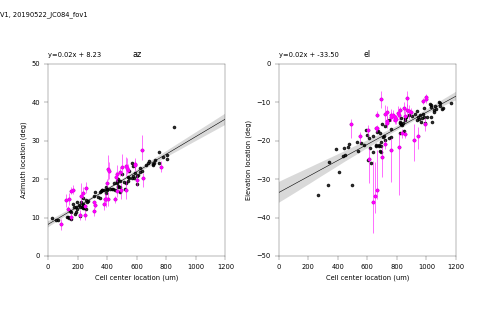

130
130
/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/combined_rfs example_scatter_V1_20190522_JC084_fov1


In [1576]:
marker='o'
marker_size=5
ci = 0.95
lw=0.5
fill_marker=True
deviant_color='magenta'
scatter_kws={'s': marker_size, 'marker': marker}
line_kws={'lw': lw}

fig, axn = pl.subplots(1, 2, figsize=(6,4), sharex=True)

for ax, cond in zip(axn.flat, ['az', 'el']):
    # Get var names for V1/V2
    if cond=='az':
        ax.set_ylim([0, 50])
    else:
        ax.set_ylim([-50, 0])
    ax.set_xlim([0, 1200])
    xname = 'ml_proj' if cond=='az' else 'ap_proj'
    yname = 'x0' if cond=='az' else 'y0'
    # Get projected cortical position
    ax = rfutils.fit_with_deviants(boot_, cis_, rfs_, xname=xname, yname=yname, ax=ax,
                          scatter_kws=scatter_kws, line_kws=line_kws, 
                          deviant_color=deviant_color,lw=lw)
    ax.set_title(cond)
    ylabel='Azimuth' if cond=='az' else 'Elevation'
    ax.set_ylabel('%s location (deg)' % ylabel)
    ax.set_xlabel('Cell center location (um)')
    currd = df_[df_.axis==cond].copy()
    # should be equivalent to'measured_loc' and 'measured_rf' in SCATTERDF:
#     sns.scatterplot(x='measured_loc', y='measured_rf', data=currd, ax=ax,
#                    color='cyan', alpha=0.5)
        
fig.text(0, 0.95, '%s, %s' % (va, dk))
pl.subplots_adjust(left=0.1, right=0.95, bottom=0.2, top=0.8, wspace=0.3)

pplot.label_figure(fg.fig, data_id)
figname = 'example_scatter_%s_%s' % (va, dk)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)
